

This excellent [Github repository](https://github.com/utkuozbulak/pytorch-cnn-visualizations#gradient-visualization) contains a number of convolutional neural network visualization techniques implemented in PyTorch.

The Pytorch code is very well documented and very fast to run. Your goal in this homework is to create a Python Notebook explaining at least two of the proposed methods for CNN visualization, with experiments that illustrate them.

Most likely, to find the explanation of the methods you have to read the corresponding papers (cited at the end of the Github website). You can copy and paste equations/figures from the original paper to support your description of the method.

**METHODS FOR CNN VISUALIZATION**


1.   Gradient visualization with guided backpropagation.

      Paper : Striving for simplicity: the all convolutional net

      
2.   Convolutional Neural Network Filter Visualization
      
      Paper : Visualizing Higher-Layer Features of a Deep Network 



Code needed in all the different techniques:

In [ ]:
"""
Created on Thu Oct 21 11:09:09 2017
@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        pil_im.thumbnail((224, 224))
    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    
    example_list = (('/content/snake.jpg', 56),
                    ('../input_images/cat_dog.png', 243),
                    ('../input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

## **1. Gradient visualization with guided backpropagation.**

This model differs from common CNN since:

> - They replace the pooling layers with standard convolutional layers with stride = 2. The reason is that, despite not using max-pooling, we can reduce the spatial dimensionality (thanks to the stride).

> As a downside: the number of network parameters increases.


> - Furthermore, they use small convolutional layers (k<5) to reduce the number of parameters (kind of regularization) 

So, mainly this architecture consists of convolutional layers with rectified linear non-linearities and an averaging+ softmax layer to produce averaging over the image.

Its corresponding equation can be found in the following image:

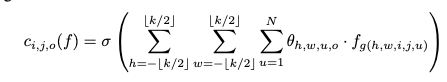

In [ ]:

from IPython.display import Image
from IPython.core.display import HTML 

display(Image("/Sin título.png", width=380, height=80))

In [ ]:
"""
Created on Thu Oct 26 11:23:47 2017
@author: Utku Ozbulak - github.com/utkuozbulak
"""
import torch
from torch.nn import ReLU




class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


if __name__ == '__main__':
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)

    # Guided backprop
    GBP = GuidedBackprop(pretrained_model)
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, target_class)
    # Save colored gradients
    save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
    # Convert to grayscale
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
    # Positive and negative saliency maps
    pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
    save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
    save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
    print('Guided backprop completed')

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 233M/233M [00:03<00:00, 76.9MB/s]


Guided backprop completed


Color guided backpropagation


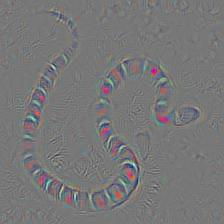

Guided backpropagation saliency


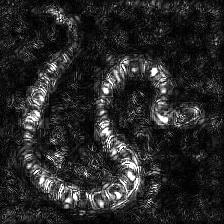

Guided Backpropagation Negative Saliency


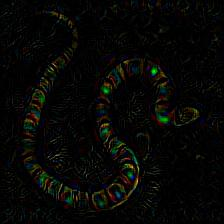

Guided Backpropagation Negative Saliency


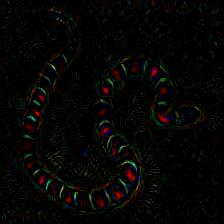

In [ ]:
from IPython.display import Image,display
from IPython.core.display import HTML 

print('Color guided backpropagation')
display(Image("/results/snake_Guided_BP_color.jpg", width=200, height=200))
print('Guided backpropagation saliency')
display(Image("/results/snake_Guided_BP_gray.jpg", width=200, height=200))
print('Guided Backpropagation Negative Saliency')
display(Image("/results/snake_neg_sal.jpg", width=200, height=200))
print('Guided Backpropagation Negative Saliency')
display(Image("/results/snake_pos_sal.jpg", width=200, height=200))


## **2. Convolutional Neural Network Filter Visualization.**

The main goal of this paper is to understand or find good interpretations of high level features.

The key concept is that there's a link between the gradient updates for maximizing the activation of each unit and finding the linear combination of weights of previous layer filters.
In this way, using this linear combination (and choosing the largest weights), they show that those networks with sparsity constraints on the activations, will tend to learn corner detectors at the second layer. 

In [ ]:
# @author: Utku Ozbulak - github.com/utkuozbulak

import os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models

#from misc_functions import preprocess_image, recreate_image, save_image


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)


if __name__ == '__main__':
    cnn_layer = 17
    filter_pos = 5
    # Fully connected layer is not needed
    pretrained_model = models.vgg16(pretrained=True).features
    layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

    # Layer visualization with pytorch hooks
    layer_vis.visualise_layer_with_hooks()

    # Layer visualization without pytorch hooks
    # layer_vis.visualise_layer_without_hooks()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.2MB/s]


Iteration: 1 Loss: 1.32
Iteration: 2 Loss: -1.80
Iteration: 3 Loss: -8.53
Iteration: 4 Loss: -15.55
Iteration: 5 Loss: -22.23
Iteration: 6 Loss: -28.43
Iteration: 7 Loss: -34.38
Iteration: 8 Loss: -40.08
Iteration: 9 Loss: -45.59
Iteration: 10 Loss: -50.93
Iteration: 11 Loss: -56.18
Iteration: 12 Loss: -61.33
Iteration: 13 Loss: -66.42
Iteration: 14 Loss: -71.47
Iteration: 15 Loss: -76.49
Iteration: 16 Loss: -81.47
Iteration: 17 Loss: -86.41
Iteration: 18 Loss: -91.36
Iteration: 19 Loss: -96.28
Iteration: 20 Loss: -101.21
Iteration: 21 Loss: -106.12
Iteration: 22 Loss: -111.04
Iteration: 23 Loss: -115.99
Iteration: 24 Loss: -120.95
Iteration: 25 Loss: -125.91
Iteration: 26 Loss: -130.90
Iteration: 27 Loss: -135.88
Iteration: 28 Loss: -140.90
Iteration: 29 Loss: -145.94
Iteration: 30 Loss: -151.01


One of the most suprising results is that the response of an internal unit to input images appears to be unimodal(the maximum is found consistently for all random initializations tested). That's the reason why is so easy to find the dominant mode. 


After the execution of the code below, we can see the image results in different iterations:



Iteration 5


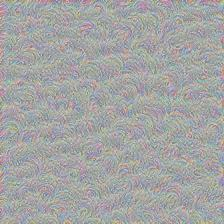

Iteration 10


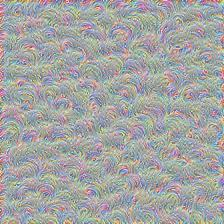

Iteration 15


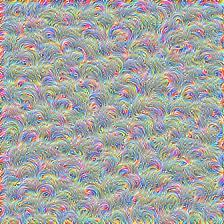

Iteration 20


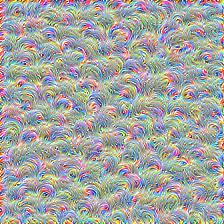

Iteration 25


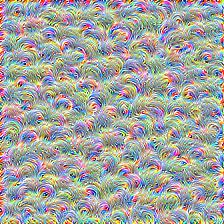

Iteration 30


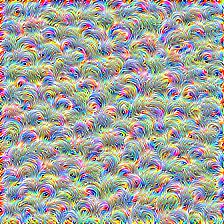

In [ ]:
from IPython.display import Image,display
from IPython.core.display import HTML 

print('Iteration 5')
display(Image("/generated/layer_vis_l17_f5_iter5.jpg", width=200, height=200))
print('Iteration 10')
display(Image("/generated/layer_vis_l17_f5_iter10.jpg", width=200, height=200))
print('Iteration 15')
display(Image("/generated/layer_vis_l17_f5_iter15.jpg", width=200, height=200))
print('Iteration 20')
display(Image("/generated/layer_vis_l17_f5_iter20.jpg", width=200, height=200))
print('Iteration 25')
display(Image("/generated/layer_vis_l17_f5_iter25.jpg", width=200, height=200))
print('Iteration 30')
display(Image("/generated/layer_vis_l17_f5_iter30.jpg", width=200, height=200))